## Audio Analysis of Elephant rumbles

Here we are looking for best way to reppresent an elephant rumble spectrogram for deeplearning

In [1]:
# load stuff we need
import json
import logging
import os
import time
import warnings
import librosa
import numpy as np
import pandas as pd
import pydub
import sklearn.preprocessing

from tqdm import tqdm

import h5py as h5py

from config import *

In [81]:
# load wav file
# setup and prepare audio files
np.random.seed(1)

filename = "EFAF2011A008-38.WAV"
category = "rumble"

# overrule settings in config
MEL_BANDS = 120  # 80 Number of mel frequency bands
MEL_FREQS = librosa.core.mel_frequencies(n_mels=MEL_BANDS)
#MEL_BANDS = 25
#MEL_FREQS = MEL_FREQS[0:25]

# current processing of the audio files
spec_file = './dataset/tmp/' + filename + '.spec.npy'
audio_file = './dataset/audio/' + filename

audio = pydub.AudioSegment.from_file(audio_file).set_frame_rate(SAMPLING_RATE).set_channels(1)
audio = (np.fromstring(audio._data, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float

spec = librosa.feature.melspectrogram(audio, SAMPLING_RATE, n_fft=FFT_SIZE, #fmax = 1000, 
                                      hop_length=CHUNK_SIZE, n_mels=MEL_BANDS) # MEL_BANDS
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore log10 zero division
    spec = librosa.core.perceptual_weighting(spec, MEL_FREQS, amin=1e-5, ref_power=1e-5,
                                             top_db=None)

spec = np.clip(spec, 0, 100)
#np.save(spec_file, spec.astype('float16'), allow_pickle=False)


In [82]:
MEL_FREQS[0:25]
spec.shape

(120, 251)

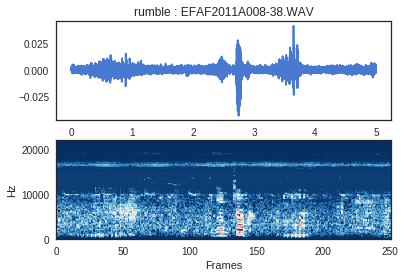

In [86]:
# You can reload this cell to get a different clip at every try
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import librosa.display

import IPython.display

#all_recordings = glob.glob('ESC-50/*/*.ogg')
#clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

plt.subplot(2, 1, 1)
plt.title('{0} : {1}'.format( category, filename))
plt.plot(np.arange(0, len(audio)) / 44100.0, audio)

plt.subplot(2, 1, 2)
librosa.display.specshow(spec, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r', fmax=750)
    
IPython.display.Audio(filename=audio_file, rate=SAMPLING_RATE) 

The main problem is that even such sub-optimal representations are very high-dimensional. Most basic classifiers will need some [dimensionality reduction](http://en.wikipedia.org/wiki/Dimensionality_reduction) applied first.

With deep learning this could be circumvented and we use the spectrum representation.

We will use [Mel-frequency cepstral coefficients](http://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (*MFCC*) and [zero-crossing rate](http://en.wikipedia.org/wiki/Zero-crossing_rate) (*ZCR*) as our baseline features. ZCR is a very simple, yet useful feature, whereas MFCCs are ubiquitous in speech processing and analyzing harmonic content. They may be less suitable for more noise-like environmental sounds, but the goal here is to get a general feel for the characteristics of the dataset, without striving for maximum classification accuracy.

So, first thing worth doing is to look at the distribution of the computed baseline features.

There are multiple ways this can be done, but each visualization perspective will have to, in some manner, reduce the number of dimensions analyzed at the same time (we have multiple categories, clips per category, features per clip).

Let's begin by looking at a **single clip / all features** perspective:

In [49]:
def get_frame(audio, index):
    if index < 0:
        return None
    return audio[(index * CHUNK_SIZE):(index+1) * CHUNK_SIZE]

def compute_mfcc(audio):
    # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
    melspectrogram = librosa.feature.melspectrogram(audio, sr=SAMPLING_RATE, hop_length=CHUNK_SIZE)
    logamplitude = librosa.logamplitude(melspectrogram)
    mfcc = librosa.feature.mfcc(S=logamplitude, n_mfcc=13).transpose()
    return mfcc

def compute_zcr(audio):
    # Zero-crossing rate
    zcr = []
    frames = int(np.ceil(len(audio) / 1000.0 * CHUNK_SIZE / CHUNK_SIZE))

    for i in range(0, frames):
        frame = get_frame(audio, i)
        zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

    zcr = np.asarray(zcr)
    return zcr

In [50]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], axisbg='w')

/home/hugo/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hugo/anaconda3/envs/py35/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


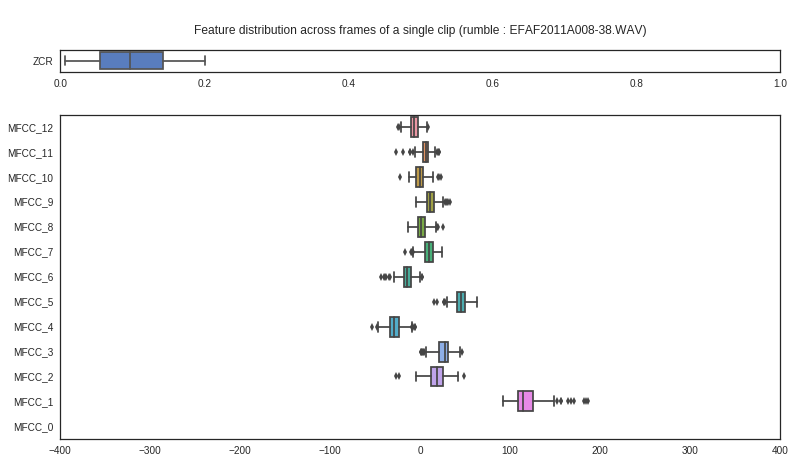

In [51]:
import seaborn as sb
sb.set(style="white", palette="muted")

def plot_single_clip(clip):
    mfcc = compute_mfcc(clip)
    zcr = compute_zcr(audio)
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(mfcc)[1]))
    MFCC = pd.DataFrame(mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip ({0} : {1})'.format(category, filename), y=1.5)
    sb.boxplot(MFCC, vert=False, order=list(reversed(MFCC.columns)), ax=ax_mfcc)
    sb.boxplot(pd.DataFrame(zcr, columns=['ZCR']), vert=False, ax=ax_zcr)
    
plot_single_clip(audio)